This notebook best viewed here: https://nbviewer.jupyter.org

<a id='home'></a>

This notebook is for the interior variety of Douglas fir GEA mapping pops

1. [Choose SNPs for GEA structure correction in baypass](#choose)
    1. [load snps and filter for depth](#depth)
        - filter for 20≤depth<1000.
    1. [reduce SNPs to those on contigs ≥ 1Kbp](#contig)
    1. [try and filter for no missing data](#missing)
        - I tried this, but I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data, so filters for nomissing data was not implemented
    1. [choose one snp per contig at random](#random)
    1. [determine threshold for LD pruning](#r2thresh)
        - an r2thresh of 0.3421. Using a threshold below this value resulted in non-converging covariance matrix estimation across replicates. This threshold corresponded roughly to the 99.0th percentile of the distribution of LD values.
    1. [LD prune random loci](#prune)
    
1. [create infiles to baypass to estimate neutral structure](#infiles)
    1. [genotype file](#genotyping)
    1. [poolsizefile](#poolsizefile)

1. [create 5 replicate estimates of the covariance matrix](#covariance)
    1. [make and rsync shfiles for cedar HPC server](#shfiles)
        - bash shfiles were submitted to slurm for execution

1. [look at covariance matrices output from chains](#look)
    1. [rsync the files from cedar HPC](#rersync)
    1. [read in matrices and look at convergence](#readin)
        - matrices were highly correlated (r > 0.965)
    1. [estimate average covariance matrix](#avg)
    1. [compare avg matrix to replicate matrices](#compare)
        - the avg matrix was highly correlated with each of the replicate matrices (r > 0.991)

1. [create infiles to baypass for GEA](#geainfiles)
    1. [environmental file](#efile)
    1. [genotype file](#gfile)
        1. [break up genotype file for parallelization](#gparallel)

1. [create commands to run baypass GEA using gfiles from above](#commands)
    1. [create catfiles to hold commands](#catfiles)
    1. [create slurm shfiles for executing commands in parallel](#geashfiles)
    1. [transfer to cedar, graham, beluga, and arc](#transfer)
        - bash shfiles were submitted to slurm for execution

In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/DF_datasets'
snpdir = op.join(DIR, 'DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI')
assert op.exists(snpdir)
baydir = makedir(op.join(snpdir, 'baypass'))
op.exists(baydir)

True

In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 4937ed6baded6e6e058c905e26e9ae16bfe3f0d9
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 1 11:28:39 2020 -0700
Today:	December 15, 2020 - 23:53:16
##################################################################



<a id='choose'></a>
# Choose SNPs for GEA structure correction in baypass


[top](#home)

In [8]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
    assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [3]:
# get parallel engines
lview,dview = get_client()

56 56


<a id='depth'></a>
#### load snps and filter for depth

[top](#home)

In [4]:
# figure making functions
def get_mafdict(afs, roundto):
    # bins for p52 depth
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['filtered snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

# filtering functions
def filter_depth(chunk):
    """Filter min/max depth, reduce columns."""
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['CHROM', 'locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[chunk[col] >= 20].copy()
        chunk = chunk[chunk[col] < 1000].copy()
    chunk.index = chunk['locus'].tolist()
    return chunk

In [5]:
f = op.join(snpdir, 'DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt')
snps = parallel_read(f,
                     lview=lview, dview=dview,
                     verbose=False,
                     assert_rowcount=False,
                     **dict(functions=create_fundict(filter_depth)))
print(snps.shape)
snps.index = snps['locus'].tolist()
snps.head()


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:33<00:00,  1.68it/s]


(1182926, 74)


,CHROM,locus,AF,MAF,DF_p18.DP,DF_p19.DP,DF_p20.DP,DF_p3.DP,DF_p33.DP,DF_p34.DP,DF_p35.DP,DF_p36.DP,DF_p37.DP,DF_p38.DP,DF_p39.DP,DF_p4.DP,DF_p40.DP,DF_p41.DP,DF_p42.DP,DF_p43.DP,DF_p44.DP,DF_p45.DP,DF_p46.DP,DF_p47.DP,DF_p48.DP,DF_p49.DP,DF_p5.DP,DF_p54.DP,DF_p55.DP,DF_p56.DP,DF_p57.DP,DF_p58.DP,DF_p59.DP,DF_p60.DP,DF_p61.DP,DF_p62.DP,DF_p7.DP,DF_p8.DP,DF_p9.DP,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p9.FREQ
jcf7190000000004-54623,jcf7190000000004,jcf7190000000004-54623,0.143139,0.143139,57.0,63.0,31.0,65.0,65.0,71.0,59.0,64.0,34.0,44.0,45.0,63.0,24.0,34.0,26.0,69.0,63.0,59.0,56.0,55.0,53.0,60.0,46.0,69.0,67.0,70.0,60.0,76.0,46.0,73.0,48.0,68.0,68.0,45.0,56.0,5.26%,20.63%,NaN,13.85%,21.54%,12.68%,22.03%,10.94%,5.88%,6.82%,8.89%,6.35%,12.5%,23.53%,11.54%,20.29%,11.11%,20.34%,1.79%,NaN,1.89%,6.67%,15.22%,NaN,17.91%,NaN,28.33%,44.74%,4.35%,21.92%,16.67%,1.47%,11.76%,15.56%,21.43%
jcf7190000000004-54643,jcf7190000000004,jcf7190000000004-54643,0.318352,0.318352,56.0,57.0,27.0,63.0,66.0,77.0,58.0,64.0,33.0,38.0,42.0,63.0,27.0,35.0,24.0,67.0,66.0,56.0,59.0,59.0,52.0,51.0,46.0,60.0,62.0,76.0,56.0,73.0,43.0,75.0,49.0,73.0,65.0,43.0,49.0,32.14%,12.28%,25.93%,42.86%,36.36%,28.57%,25.86%,42.19%,48.48%,26.32%,30.95%,55.56%,29.63%,31.43%,54.17%,35.82%,30.3%,23.21%,47.46%,35.59%,15.38%,31.37%,8.7%,25%,16.13%,26.32%,39.29%,16.44%,32.56%,13.33%,16.33%,41.1%,35.38%,58.14%,42.86%
jcf7190000000004-54644,jcf7190000000004,jcf7190000000004-54644,0.832645,0.167355,57.0,58.0,26.0,62.0,67.0,76.0,60.0,63.0,32.0,39.0,42.0,63.0,26.0,34.0,24.0,67.0,63.0,54.0,59.0,56.0,52.0,52.0,45.0,61.0,61.0,72.0,52.0,74.0,43.0,74.0,49.0,72.0,66.0,42.0,48.0,80.7%,96.55%,84.62%,90.32%,92.54%,89.47%,90%,77.78%,87.5%,92.31%,90.48%,90.48%,76.92%,73.53%,83.33%,83.58%,68.25%,77.78%,86.44%,82.14%,53.85%,78.85%,75.56%,100%,90.16%,83.33%,84.62%,85.14%,83.72%,95.95%,81.63%,86.11%,69.7%,78.57%,75%
jcf7190000000004-54649,jcf7190000000004,jcf7190000000004-54649,0.147113,0.147113,54.0,57.0,26.0,60.0,69.0,76.0,60.0,61.0,33.0,41.0,42.0,58.0,26.0,33.0,24.0,68.0,70.0,52.0,58.0,56.0,52.0,53.0,44.0,62.0,63.0,74.0,51.0,73.0,42.0,74.0,46.0,71.0,63.0,43.0,52.0,7.41%,21.05%,NaN,11.67%,24.64%,13.16%,18.33%,13.11%,6.06%,17.07%,7.14%,NaN,11.54%,21.21%,12.5%,19.12%,10%,19.23%,3.45%,12.5%,1.92%,NaN,15.91%,NaN,17.46%,4.05%,27.45%,42.47%,7.14%,29.73%,NaN,1.41%,14.29%,9.3%,21.15%
jcf7190000000004-54700,jcf7190000000004,jcf7190000000004-54700,0.832725,0.167275,56.0,61.0,34.0,53.0,69.0,71.0,68.0,60.0,26.0,51.0,40.0,63.0,26.0,35.0,28.0,60.0,78.0,58.0,66.0,63.0,63.0,56.0,45.0,62.0,73.0,80.0,51.0,73.0,42.0,92.0,58.0,65.0,62.0,36.0,57.0,87.5%,96.72%,85.29%,88.68%,89.86%,88.73%,85.29%,86.67%,92.31%,94.12%,87.5%,92.06%,80.77%,74.29%,71.43%,81.67%,80.77%,77.59%,86.36%,82.54%,52.38%,80.36%,68.89%,100%,90.41%,83.75%,78.43%,87.67%,83.33%,91.3%,75.86%,84.62%,72.58%,80.56%,77.19%


In [6]:
luni(snps['CHROM'])  # how many unique contigs?

27248

<a id='contig'></a>
#### reduce snps to those on contigs > 1Kbp

[top](#home)


In [7]:
# get contig lengths
lengths = pd.read_table('/data/database/DouglasFir_ref_genome/DF_ref_edit.fasta.length', header=None)
lengths.head()

,0,1
0,jcf7190000000000,104664
1,jcf7190000000004,713351
2,jcf7190000000008,780568
3,jcf7190000000009,80234
4,jcf7190000000010,335878


In [8]:
# map contig name to its length
lens = dict((contig,length) for (contig,length) in zip(lengths[0],lengths[1]) if length>1000)
len(lens.keys())

79910

In [9]:
# reduce file to contigs I have measurements for, 
#     and reduce columns to frequency cols, and contig and global freq info
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['CHROM'].isin(list(lens.keys()))].copy()
reduced = reduced.loc[:, freqcols + ['CHROM', 'AF', 'MAF']]
reduced.shape, snps.shape

((1180452, 38), (1182926, 74))

In [10]:
len(freqcols)  # num pops

35

In [11]:
min(lens.values())  # how many contigs >1Kbp?

1001

46
46


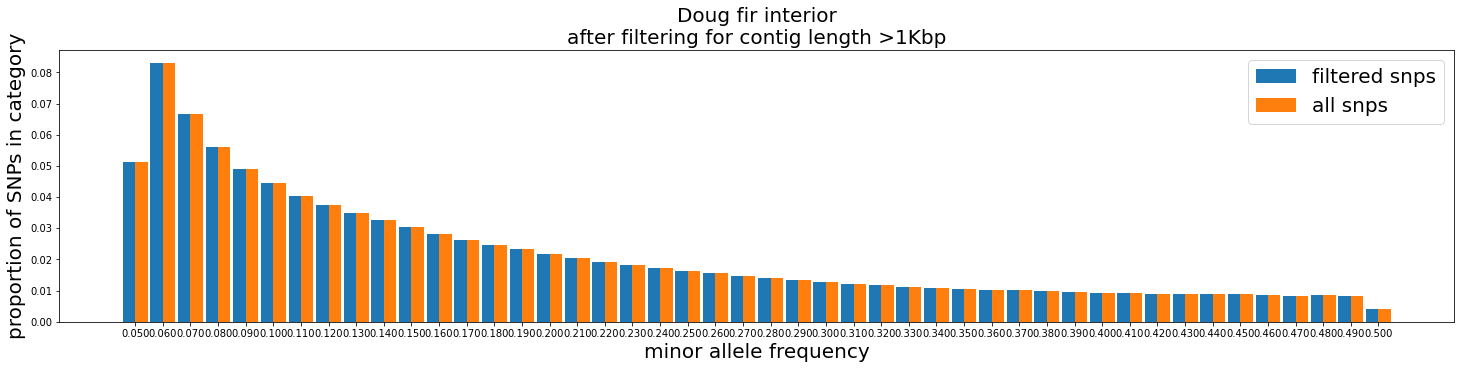

In [12]:
# compare MAF spectrum between depth-filtered and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for contig length >1Kbp')

<a id='missing'></a>
#### try and reduce to no missing data 

Turns out I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data. Filter instead for % missing below.

[top](#home)

In [13]:
def reduce_col(col):
    """Return list of loci with no missing data for pop.FREQ col."""
    return reduced[reduced[col].notnull()].index

In [14]:
# # get loci from each pop without missing data
reduce_col_outs = []
for col in nb(freqcols):
    reduce_col_outs.append(reduce_col(col))

100%|██████████| 35/35 [00:24<00:00,  1.44it/s]


In [15]:
# # combine returns to get loci with no missing data across pop.FREQ cols
nomissingloci = snps.index.tolist()
for out in nb(reduce_col_outs):
    nomissingloci = list(set(nomissingloci).intersection(out))
len(nomissingloci), luni(nomissingloci)

100%|██████████| 35/35 [00:17<00:00,  2.04it/s]


(395587, 395587)

In [16]:
# reduce snp table to no missing loci
reduced_nm = reduced[reduced.index.isin(nomissingloci)]
reduced_nm.head()

,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p9.FREQ,CHROM,AF,MAF
jcf7190000000004-54643,32.14%,12.28%,25.93%,42.86%,36.36%,28.57%,25.86%,42.19%,48.48%,26.32%,30.95%,55.56%,29.63%,31.43%,54.17%,35.82%,30.3%,23.21%,47.46%,35.59%,15.38%,31.37%,8.7%,25%,16.13%,26.32%,39.29%,16.44%,32.56%,13.33%,16.33%,41.1%,35.38%,58.14%,42.86%,jcf7190000000004,0.318352,0.318352
jcf7190000000004-54644,80.7%,96.55%,84.62%,90.32%,92.54%,89.47%,90%,77.78%,87.5%,92.31%,90.48%,90.48%,76.92%,73.53%,83.33%,83.58%,68.25%,77.78%,86.44%,82.14%,53.85%,78.85%,75.56%,100%,90.16%,83.33%,84.62%,85.14%,83.72%,95.95%,81.63%,86.11%,69.7%,78.57%,75%,jcf7190000000004,0.832645,0.167355
jcf7190000000004-54700,87.5%,96.72%,85.29%,88.68%,89.86%,88.73%,85.29%,86.67%,92.31%,94.12%,87.5%,92.06%,80.77%,74.29%,71.43%,81.67%,80.77%,77.59%,86.36%,82.54%,52.38%,80.36%,68.89%,100%,90.41%,83.75%,78.43%,87.67%,83.33%,91.3%,75.86%,84.62%,72.58%,80.56%,77.19%,jcf7190000000004,0.832725,0.167275
jcf7190000000004-55345,89.83%,95.71%,86.67%,91.18%,92.31%,89.47%,92%,77.78%,88.89%,94.23%,88.89%,79.41%,80%,71.05%,87.5%,78.43%,86.11%,75.41%,76.74%,82.46%,55.36%,79.1%,70%,100%,87.93%,89.61%,80.3%,85.54%,86.49%,93.51%,74.29%,87.84%,75%,81.58%,68%,jcf7190000000004,0.833096,0.166904
jcf7190000000004-289701,61.64%,83.33%,79.41%,83.33%,86.13%,67.71%,78.26%,66.27%,90.48%,85.51%,76.71%,69.03%,71.88%,87.1%,78.57%,65.12%,64.35%,66.35%,72.86%,84.35%,49.18%,69.5%,69.62%,86.11%,68.97%,75.45%,64.22%,58.7%,79.1%,79.22%,68.32%,85.91%,68.75%,86.42%,69.86%,jcf7190000000004,0.741632,0.258368


46
46


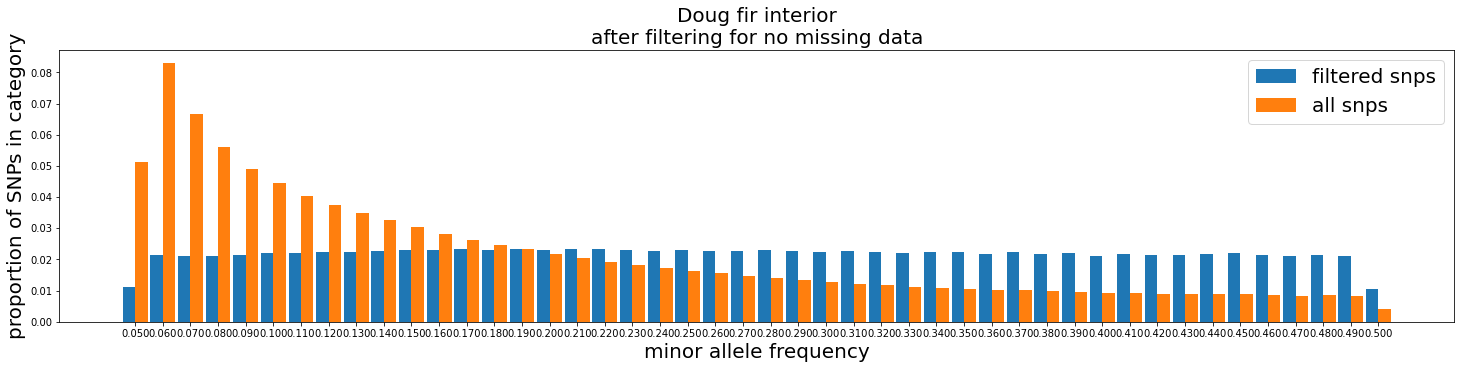

In [17]:
# # compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced_nm['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for no missing data')

In [18]:
del reduce_col_outs, nomissingloci, reduced_nm

<center> SETTING PERC TO 0.25 MEANS NO LOCI WERE FILTERED BY MAF
    
    if I tried filtering <= 10% missing data, the MAF spectrum looked weird, leaving the code inplace. As-is (<25% missing data) will allow more contigs

<a id='random'></a>
#### choose one snp per contig at random

[top](#home)

In [19]:
def choose_random_loci(df):
    """For each chrom in df['CHROM'], randomly choose 1 snp."""
    import pandas
    import random

    keep = []
    for chrom in uni(df['CHROM']):
        loci = df.loc[chrom, 'locus']
        if isinstance(loci, str):
            keep.append(loci)
            continue
        loci = loci.tolist()
        random.shuffle(loci)
        keep.append(loci[0])
    return keep
        
dview['uni'] = uni

In [20]:
# how many chroms do I send to a job? A: math.ceil(478.26)
luni(reduced['CHROM']), luni(reduced['CHROM'])/len(lview)

(26783, 478.26785714285717)

In [21]:
# change the index for easy sending
reduced['locus'] = reduced.index.tolist()
reduced.index = reduced['CHROM'].tolist()

In [22]:
nrow(reduced), luni(reduced['locus'])  # all unique loci names?  # (1240589, 1240589)

(1180452, 1180452)

In [23]:
# choose random loci in parallel
jobs = []
tosend = []
i = 0
numchroms = luni(reduced['CHROM'])
for chrom in nb(uni(reduced['CHROM'])):
    tosend.append(chrom)
    if len(tosend) == 477 or (i+1)==numchroms:
        jobs.append(lview.apply_async(choose_random_loci, reduced.loc[tosend, :]))
        tosend = []
    i += 1
watch_async(jobs)

100%|██████████| 26783/26783 [00:17<00:00, 1563.07it/s]



Watching 57 jobs ...


100%|██████████| 57/57 [00:00<00:00, 339595.64it/s]


In [24]:
# get returns from jobs
randomloci = []
for j in jobs:
    randomloci.extend(j.r)
len(randomloci) == luni(reduced['CHROM'])

True

In [25]:
# reduce reduced to only randomloci
red = reduced[reduced['locus'].isin(randomloci)].copy()
print(nrow(red), len(randomloci))
red.head()

26783 26783


,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p9.FREQ,CHROM,AF,MAF,locus
jcf7190000000004,9.64%,22.62%,NaN,16.13%,16%,14.93%,27.59%,13.79%,8.57%,5.56%,31.88%,16.98%,33.33%,39.39%,27.78%,26.09%,13.58%,20.9%,NaN,15.09%,44.93%,11.63%,13.64%,17.72%,12.5%,1.59%,3.39%,NaN,7.55%,8.75%,24.18%,22.58%,46.38%,30.16%,21.43%,jcf7190000000004,0.196331,0.196331,jcf7190000000004-480005
jcf7190000000008,17.95%,17.39%,NaN,30.56%,9.52%,31.11%,22.86%,11.11%,NaN,60%,29.63%,16.98%,17.07%,21.21%,9.52%,28.21%,31.91%,42.42%,22.22%,30.3%,21.82%,22.73%,31.58%,17.31%,7.69%,40.62%,34%,27.08%,35.48%,18.37%,48.08%,31.58%,14.29%,24.24%,26.09%,jcf7190000000008,0.257728,0.257728,jcf7190000000008-431360
jcf7190000000011,12.16%,6.67%,11.36%,9.5%,13.29%,10.13%,11.18%,9.26%,9.68%,NaN,10.2%,7.59%,14.04%,NaN,10.14%,NaN,12.78%,2.63%,14%,14.84%,6.72%,8.88%,6.77%,12.37%,8.61%,11.38%,5.65%,12.22%,6.14%,2.16%,14.07%,4.32%,9.94%,9.92%,6.61%,jcf7190000000011,0.095260,0.095260,jcf7190000000011-191141
jcf7190000000014,100%,100%,98.51%,100%,100%,98.85%,58.9%,0%,100%,100%,10.39%,0%,3.17%,65.22%,78.26%,0%,0%,34.34%,100%,100%,100%,0%,97.59%,100%,100%,100%,100%,100%,100%,100%,100%,97.14%,66.13%,100%,62.5%,jcf7190000000014,0.731705,0.268295,jcf7190000000014-15050
jcf7190000000023,5%,4.6%,2.56%,4.17%,11.54%,NaN,NaN,0%,7.69%,8.89%,1.59%,NaN,0%,5.13%,10.81%,5.77%,1.75%,6.67%,12%,12%,NaN,7.95%,4.88%,NaN,NaN,5.06%,2.63%,4.21%,3.7%,7.78%,11.34%,11.34%,0%,2.04%,6.78%,jcf7190000000023,0.057874,0.057874,jcf7190000000023-30408


In [26]:
# reset index
reduced = red.copy()
reduced.index = reduced['locus'].tolist()
reduced.shape

(26783, 39)

46
46


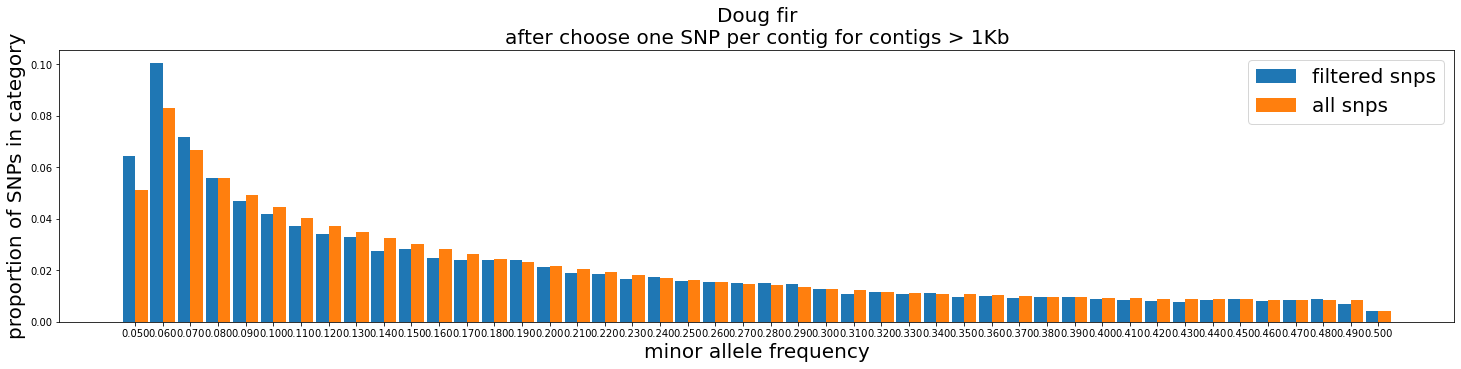

In [27]:
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter choose one SNP per contig for contigs > 1Kb')

<a id='r2thresh'></a>
#### get an idea of r2 values so we can determine an empirical high-end cutoff

[top](#home)

In [28]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    from tqdm import tqdm
    rets = []
    for locus in tqdm(myloci):
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci):
    from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
                r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [29]:
time.sleep(30)

In [33]:
jobs = send_chunks(getr2, randomloci, 240, lview)
watch_async(jobs)


Watching 112 jobs ...


100%|██████████| 112/112 [01:55<00:00,  1.03s/it]


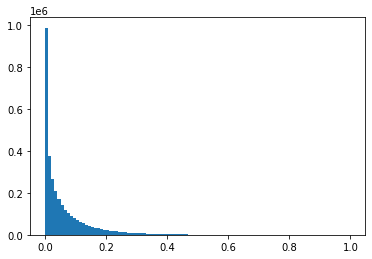

In [34]:
r2vals = []
for j in jobs:
    r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [35]:
# what is 99.99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.9999)]

0.7040088002055883

In [36]:
# get 99.9th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.999)]  # 0.621662565701289

0.5597625747370389

In [37]:
# what is 99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.99)]  # 0.4289482383901882

0.37795671494102473

In [56]:
# what is 98.5th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.985)]

0.34213660559188114

In [38]:
# what is 98th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.98)]  # 0.3613398279138897

0.31638090268026764

In [39]:
# what is 97th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.97)]  # 0.3198894602925643

0.2789454381426994

In [40]:
# what perc is 0.2
for i,x in enumerate(sorted(r2vals)):
    if x > 0.2:
        print(i) # 2907882
        break
(i+1)/len(r2vals)  # 0.9064442110703486

2972664


0.9308098331899752

In [41]:
# what perc is 0.3
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3:
        print(i) # 3091524
        break
(i+1)/len(r2vals) # 0.9636890272508417

3117241


0.9760802196119591

In [42]:
# what perc is 0.3606818877742702 (to compare with jack pine)
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3606818877742702:
        print(i) # 3143413
        break
(i+1)/len(r2vals) # 0.9798638471002749

3154842


0.9878539581724012

In [43]:
# use 98.5th percentile
r2thresh = 0.34213660559188114

<a id='prune'></a>
#### LD prune random loci

[top](#home)

In [44]:
# number of loci starting out
reduced.shape

(26783, 39)

In [45]:
len(randomloci)

26783

In [46]:
snps.shape, reduced.shape

((1182926, 74), (26783, 39))

In [47]:
# num pops
len(freqcols)

35

In [48]:
lview,dview=get_client()

56 56


In [49]:
# set up objects on engines
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))
dview['freqs'] = freqs
dview['reduced'] = None
len(freqs)

100%|██████████| 26783/26783 [00:26<00:00, 1008.93it/s]


26783

In [50]:
def prune_em(compareto, locusi=None, r2thresh=0.2):
    """For a set of pairwise LD comparisons, drop one locus in pair if r2 > r2thresh."""
    from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
        nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
        r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
#         print('r2 = ', r2)
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [51]:
r2thresh

0.34213660559188114

In [52]:
# send locus along with all needed loci for pairwise comparisons to engines
# each locus (job) has r2 calculated for each of the remaining unique pairwise combinations
# so the first job compares locus1 to locus2-locusn, second job locus2 to locus3-locusn ... 
jobs = []
for i,locusi in enumerate(nb(randomloci)):
    tosend = randomloci[i+1:]
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))

100%|██████████| 26783/26783 [05:31<00:00, 80.91it/s] 


In [53]:
# iterate jobs, if finished jobs are an unbroken sequenced 0:(n-1), check returns and cancel any loci iterations
    # downstream. eg if locus0 has r2 > r2thresh with locus100, drop locus100 and kill jobs[100] to save some time

# t1 = dt.now()
# found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
# keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0  # jcount
    for j in tnb(jobs):
        if j.ready() and i-1 in found.keys() and i not in found.keys():
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(True, 26561, 26563, 3365)


3365

In [54]:
t2 = dt.now()
formatclock(t2-t1, exact=True)

'0-03:17:27'

In [55]:
# save pruned loci
baydir = makedir(op.join(snpdir, 'baypass'))
pkl = op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3421.pkl')
pkldump(keep, pkl)

In [56]:
op.exists(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3421.pkl'))

True

In [60]:
reduced.head()

,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p9.FREQ,CHROM,AF,MAF,locus
jcf7190000000004-480005,9.64%,22.62%,NaN,16.13%,16%,14.93%,27.59%,13.79%,8.57%,5.56%,31.88%,16.98%,33.33%,39.39%,27.78%,26.09%,13.58%,20.9%,NaN,15.09%,44.93%,11.63%,13.64%,17.72%,12.5%,1.59%,3.39%,NaN,7.55%,8.75%,24.18%,22.58%,46.38%,30.16%,21.43%,jcf7190000000004,0.196331,0.196331,jcf7190000000004-480005
jcf7190000000008-431360,17.95%,17.39%,NaN,30.56%,9.52%,31.11%,22.86%,11.11%,NaN,60%,29.63%,16.98%,17.07%,21.21%,9.52%,28.21%,31.91%,42.42%,22.22%,30.3%,21.82%,22.73%,31.58%,17.31%,7.69%,40.62%,34%,27.08%,35.48%,18.37%,48.08%,31.58%,14.29%,24.24%,26.09%,jcf7190000000008,0.257728,0.257728,jcf7190000000008-431360
jcf7190000000011-191141,12.16%,6.67%,11.36%,9.5%,13.29%,10.13%,11.18%,9.26%,9.68%,NaN,10.2%,7.59%,14.04%,NaN,10.14%,NaN,12.78%,2.63%,14%,14.84%,6.72%,8.88%,6.77%,12.37%,8.61%,11.38%,5.65%,12.22%,6.14%,2.16%,14.07%,4.32%,9.94%,9.92%,6.61%,jcf7190000000011,0.095260,0.095260,jcf7190000000011-191141
jcf7190000000014-15050,100%,100%,98.51%,100%,100%,98.85%,58.9%,0%,100%,100%,10.39%,0%,3.17%,65.22%,78.26%,0%,0%,34.34%,100%,100%,100%,0%,97.59%,100%,100%,100%,100%,100%,100%,100%,100%,97.14%,66.13%,100%,62.5%,jcf7190000000014,0.731705,0.268295,jcf7190000000014-15050
jcf7190000000023-30408,5%,4.6%,2.56%,4.17%,11.54%,NaN,NaN,0%,7.69%,8.89%,1.59%,NaN,0%,5.13%,10.81%,5.77%,1.75%,6.67%,12%,12%,NaN,7.95%,4.88%,NaN,NaN,5.06%,2.63%,4.21%,3.7%,7.78%,11.34%,11.34%,0%,2.04%,6.78%,jcf7190000000023,0.057874,0.057874,jcf7190000000023-30408


46
46


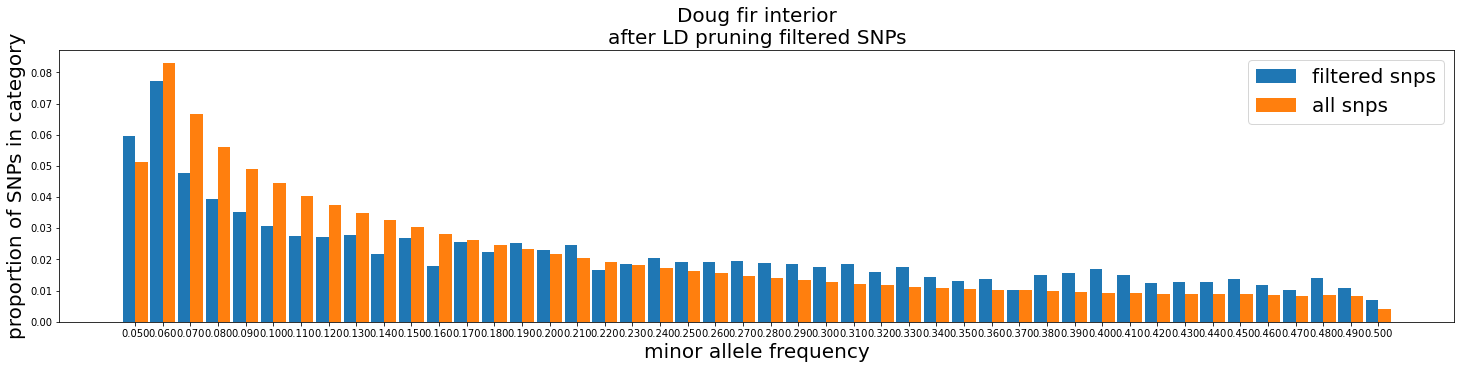

In [70]:
# compare MAF spectrum between rdpruned and precursor
make_mafdict_fig(get_mafdict(pd.Series(reduced['AF'][reduced.index.isin(keep)]), roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter LD pruning filtered SNPs')

In [58]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

<a id='infiles'></a>
# create infiles to baypass to estimate neutral structure

[top](#home)

<a id='genotyping'></a>
#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [1]:
# RESTART NOTEBOOK!

In [2]:
lview,dview = get_client()

56 56


In [3]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

In [4]:
# how many files currently in baydir?
fs(baydir, bnames=True, dirs=False)

['lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3421.pkl']

In [5]:
# reload pruned loci
prunedloci = pklload(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3421.pkl'))
len(prunedloci)

3365

In [6]:
f = op.join(snpdir, 'DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt')
snps = parallel_read(f,
                     lview=lview, dview=dview,
                     verbose=False)
print(snps.shape)
snps.index = snps['locus'].tolist()
snps.head()


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:25<00:00,  2.21it/s]


(2483660, 295)


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,DF_p20.PVAL,DF_p20.AD,DF_p20.RD,DF_p3.GT,DF_p3.GQ,DF_p3.SDP,DF_p3.DP,DF_p3.FREQ,DF_p3.PVAL,DF_p3.AD,DF_p3.RD,DF_p33.GT,DF_p33.GQ,DF_p33.SDP,DF_p33.DP,DF_p33.FREQ,...,DF_p60.GT,DF_p60.GQ,DF_p60.SDP,DF_p60.DP,DF_p60.FREQ,DF_p60.PVAL,DF_p60.AD,DF_p60.RD,DF_p61.GT,DF_p61.GQ,DF_p61.SDP,DF_p61.DP,DF_p61.FREQ,DF_p61.PVAL,DF_p61.AD,DF_p61.RD,DF_p62.GT,DF_p62.GQ,DF_p62.SDP,DF_p62.DP,DF_p62.FREQ,DF_p62.PVAL,DF_p62.AD,DF_p62.RD,DF_p7.GT,DF_p7.GQ,DF_p7.SDP,DF_p7.DP,DF_p7.FREQ,DF_p7.PVAL,DF_p7.AD,DF_p7.RD,DF_p8.GT,DF_p8.GQ,DF_p8.SDP,DF_p8.DP,DF_p8.FREQ,DF_p8.PVAL,DF_p8.AD,DF_p8.RD,DF_p9.GT,DF_p9.GQ,DF_p9.SDP,DF_p9.DP,DF_p9.FREQ,DF_p9.PVAL,DF_p9.AD,DF_p9.RD,locus,MAF
jcf7190000000000-77657,jcf7190000000000,77657,T,C,0.801333,-10.0,SNP,PASS,16,5,51,26,5,C/C,160.0,43,43.0,81.4%,9.593300e-17,35.0,8.0,C/C,128.0,34,34.0,82.35%,1.349000e-13,28.0,6.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,71.0,20,20.0,80%,7.708600e-08,16.0,4.0,C/C,47.0,11,11.0,90.91%,...,T/C,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,T/C,93.0,30,30.0,73.33%,4.135100e-10,22.0,8.0,C/C,82.0,19,19.0,89.47%,5.941400e-09,17.0,2.0,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,C/C,93.0,21,21.0,90.48%,4.700300e-10,19.0,2.0,T/C,49.0,17,17.0,70.59%,1.128500e-05,12.0,5.0,jcf7190000000000-77657,0.198667
jcf7190000000000-77738,jcf7190000000000,77738,T,C,0.789830,-10.0,SNP,PASS,13,2,49,28,8,T/C,103.0,32,32.0,75%,4.196400e-11,24.0,8.0,C/C,126.0,27,27.0,92.59%,2.085300e-13,25.0,2.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,T/C,29.0,9,9.0,77.78%,...,C/C,71.0,17,17.0,88.24%,7.327700e-08,15.0,2.0,T/C,55.0,17,17.0,76.47%,2.564700e-06,13.0,4.0,C/C,64.0,14,14.0,92.86%,3.739100e-07,13.0,1.0,C/C,63.0,17,17.0,82.35%,4.885100e-07,14.0,3.0,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,T/C,18.0,9,9.0,NaN,1.470600e-02,5.0,4.0,jcf7190000000000-77738,0.210170
jcf7190000000000-77764,jcf7190000000000,77764,T,C,0.934369,-10.0,SNP,PASS,12,1,28,50,8,C/C,127.0,29,29.0,89.66%,1.649600e-13,26.0,3.0,C/C,117.0,21,21.0,100%,1.857800e-12,21.0,0.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,58.0,11,11.0,100%,...,C/C,64.0,12,12.0,100%,3.698000e-07,12.0,0.0,C/C,65.0,16,16.0,87.5%,2.545400e-07,14.0,2.0,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,C/C,58.0,11,11.0,100%,1.417600e-06,11.0,0.0,C/C,52.0,10,10.0,100%,5.412500e-06,10.0,0.0,jcf7190000000000-77764,0.065631
jcf7190000000004-54349,jcf7190000000004,54349,C,T,0.567102,-10.0,SNP,PASS,20,16,67,3,1,C/T,55.0,22,22.0,63.64%,2.781700e-06,14.0,8.0,C/T,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,C/T,37.0,12,12.0,75%,0.000168,9.0,3.0,C/T,17.0,10,10.0,NaN,1.625400e-02,5.0,5.0,C/T,69.0,21,21.0,76.19%,...,C/T,79.0,27,27.0,70.37%,1.208900e-08,19.0,8.0,C/T,35.0,14,14.0,64.29%,2.898600e-04,9.0,5.0,C/T,27.0,20,20.0,40%,1.638000e-03,8.0,12.0,C/T,35.0,23,23.0,43.48%,2.806600e-04,10.0,13.0,C/T,24.0,18,18.0,38.89%,3.812300e-03,7.0,11.0,C/C,6.0,22,22.0,NaN,1.000000e+00,0.0,22.0,jcf7190000000004-54349,0.432898
jcf7190000000004-54418,jcf7190000000004,54418,T,C,0.545079,-10.0,SNP,PASS,36,1,86,0,0,T/C,89.0,39,39.0,58.97%,1.093000e-09,23.0,16.0,T/C,95.0,38,38.0,63.16%,2.566500e-10,24.0,14.0,T/C,59.0,19,19.0,73.68%,0.000001,14.0,5.0,T/C,86.0,36,36.0,61.11%,2.119400e-09,22.0,14.0,T/C,83.0,34,34.0,61.76%,...,T/C,78.0,41,41.0,51.22%,1.468200e-08,21.0,20.0,T/C,41.0,32,32.0,37.5%,6.875100e-05,12.0,20.0,T/C,66.0,37,37.0,48.65%,2.432000e-07,18.0,19.0,T/C,70.0,38,38.0,50%,9.241500e-08,19.0,19.0,T/C,45.0,21,21.0,57.14%,2.658000e-05,12.0,9.0,T/C,88.0,40,40.0,57.5%,1.298900e-09,23.0,17.0,jcf7190000000004-54418,0.454921


In [7]:
# get the returns, reduce to pruned loci - very important to reload without filtering for lower depth
reduced = snps[snps['locus'].isin(prunedloci)].copy()
print(reduced.shape)
reduced.head()

(3365, 295)


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,DF_p20.PVAL,DF_p20.AD,DF_p20.RD,DF_p3.GT,DF_p3.GQ,DF_p3.SDP,DF_p3.DP,DF_p3.FREQ,DF_p3.PVAL,DF_p3.AD,DF_p3.RD,DF_p33.GT,DF_p33.GQ,DF_p33.SDP,DF_p33.DP,DF_p33.FREQ,...,DF_p60.GT,DF_p60.GQ,DF_p60.SDP,DF_p60.DP,DF_p60.FREQ,DF_p60.PVAL,DF_p60.AD,DF_p60.RD,DF_p61.GT,DF_p61.GQ,DF_p61.SDP,DF_p61.DP,DF_p61.FREQ,DF_p61.PVAL,DF_p61.AD,DF_p61.RD,DF_p62.GT,DF_p62.GQ,DF_p62.SDP,DF_p62.DP,DF_p62.FREQ,DF_p62.PVAL,DF_p62.AD,DF_p62.RD,DF_p7.GT,DF_p7.GQ,DF_p7.SDP,DF_p7.DP,DF_p7.FREQ,DF_p7.PVAL,DF_p7.AD,DF_p7.RD,DF_p8.GT,DF_p8.GQ,DF_p8.SDP,DF_p8.DP,DF_p8.FREQ,DF_p8.PVAL,DF_p8.AD,DF_p8.RD,DF_p9.GT,DF_p9.GQ,DF_p9.SDP,DF_p9.DP,DF_p9.FREQ,DF_p9.PVAL,DF_p9.AD,DF_p9.RD,locus,MAF
jcf7190000000027-177437,jcf7190000000027,177437,A,G,0.493478,-10.0,SNP,PASS,56,0,85,2,0,A/G,66.0,50,50.0,38%,2.297500e-07,19.0,31.0,A/G,172.0,68,68.0,63.24%,5.054700e-18,43.0,25.0,G/G,89.0,25,25.0,80%,1.127300e-09,20.0,5.0,A/G,144.0,63,63.0,58.73%,3.421100e-15,37.0,26.0,A/G,127.0,66,66.0,51.52%,...,A/G,41.0,97,97.0,13.4%,7.940100e-05,13.0,84.0,A/G,70.0,71,71.0,29.58%,8.397500e-08,21.0,50.0,A/G,110.0,62,62.0,48.39%,8.634400e-12,30.0,32.0,A/G,101.0,75,75.0,38.67%,6.387500e-11,29.0,46.0,A/G,81.0,44,44.0,50%,6.940700e-09,22.0,22.0,A/G,166.0,63,63.0,65.08%,2.094700e-17,41.0,22.0,jcf7190000000027-177437,0.493478
jcf7190000000089-794675,jcf7190000000089,794675,T,G,0.914562,-10.0,SNP,PASS,50,0,19,68,0,G/G,141.0,38,38.0,81.58%,6.583800e-15,31.0,7.0,G/G,223.0,58,58.0,82.76%,4.734400e-23,48.0,10.0,G/G,126.0,25,25.0,96%,2.056800e-13,24.0,1.0,G/G,255.0,56,56.0,91.07%,1.523100e-26,51.0,5.0,G/G,255.0,60,60.0,93.33%,...,G/G,255.0,65,65.0,93.85%,9.093500e-33,61.0,4.0,G/G,255.0,75,75.0,92%,3.496200e-36,69.0,6.0,G/G,255.0,70,70.0,92.86%,1.839600e-34,65.0,5.0,G/G,255.0,64,64.0,100%,4.175200e-38,64.0,0.0,G/G,195.0,43,43.0,90.7%,2.687200e-20,39.0,4.0,G/G,209.0,49,49.0,87.76%,1.137800e-21,43.0,6.0,jcf7190000000089-794675,0.085438
jcf7190000000090-26387,jcf7190000000090,26387,T,A,0.530224,-10.0,SNP,PASS,107,0,86,1,0,T/A,154.0,89,89.0,47.19%,3.745800e-16,42.0,47.0,T/A,255.0,195,195.0,38.97%,1.404300e-27,76.0,119.0,T/A,255.0,83,83.0,74.7%,8.833600e-28,62.0,21.0,T/A,250.0,79,79.0,73.42%,8.817800e-26,58.0,21.0,T/A,181.0,111,111.0,45.05%,...,T/A,159.0,113,113.0,39.82%,1.149400e-16,45.0,68.0,T/A,230.0,116,116.0,52.59%,7.976500e-24,61.0,55.0,T/A,213.0,165,165.0,36.97%,4.601400e-22,61.0,104.0,T/A,136.0,60,60.0,58.33%,2.259100e-14,35.0,25.0,T/A,212.0,106,106.0,52.83%,5.948400e-22,56.0,50.0,T/A,164.0,65,65.0,63.08%,3.393300e-17,41.0,24.0,jcf7190000000090-26387,0.469776
jcf7190000000097-168264,jcf7190000000097,168264,C,A,0.109321,-10.0,SNP,PASS,80,19,68,0,0,C/C,74.0,51,51.0,3.92%,2.475200e-01,2.0,49.0,C/C,141.0,102,102.0,3.92%,6.065700e-02,4.0,98.0,C/C,34.0,23,23.0,4.35%,5.000000e-01,1.0,22.0,C/C,145.0,78,78.0,0%,1.000000e+00,0.0,78.0,C/A,18.0,100,100.0,NaN,...,C/A,108.0,137,137.0,24.09%,1.299000e-11,33.0,104.0,C/C,162.0,102,102.0,1.96%,2.487700e-01,2.0,100.0,C/A,21.0,118,118.0,5.93%,7.129300e-03,7.0,111.0,C/A,74.0,107,107.0,21.5%,3.171200e-08,23.0,84.0,C/C,75.0,61,61.0,6.56%,5.941400e-02,4.0,57.0,C/A,45.0,68,68.0,20.59%,2.899400e-05,14.0,54.0,jcf7190000000097-168264,0.109321
jcf7190000000129-18966,jcf7190000000129,18966,T,C,0.280651,-10.0,SNP,PASS,40,44,43,0,0,T/C,46.0,58,58.0,24.14%,2.505500e-05,14.0,44.0,T/C,114.0,75,75.0,42.67%,3.367000e-12,32.0,43.0,T/C,37.0,33,33.0,33.33%,1.801900e-04,11.0,22.0,T/C,57.0,58,58.0,29.31%,1.932600e-06,17.0,41.0,T/C,87.0,68,68.0,36.76%,...,T/C,47.0,42,42.0,33.33%,1.665600e-05,14.0,28.0,T/C,34.0,71,71.0,15.49%,3.212400e-04,11.0,60.0,T/C,73.0,76,76.0,28.95%,4.028000e-08,22.0,54.0,T/C,42.0,62,62.0,20.97%,6.055700e-05,13.0,49.0,T/C,15.0,40,40.0,NaN,2.737100e-02,5.0,35.0,T/T,29.0,31,31.0,12.9%,5.640500e-02,4

In [8]:
# triple check
assert len(set(prunedloci).intersection(reduced.index)) == len(prunedloci)

In [10]:
# get the gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci, numpops=35)
neutral_read_counts.head()

100%|██████████| 3365/3365 [00:04<00:00, 705.52it/s]


,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000075259-221936,57,24,67,25,31,1,72,16,60,18,61,25,101,11,58,18,20,25,67,3,44,13,99,28,16,14,45,24,32,3,62,24,118,25,75,17,68,9,84,12,82,49,79,9,61,16,94,14,86,17,92,15,87,20,83,33,40,21,119,13,107,5,114,13,94,27,65,2,106,11
jcf7190000132587-125732,79,0,108,2,46,0,75,0,90,0,59,0,86,7,62,7,36,0,26,14,61,3,76,4,27,3,54,9,32,3,69,8,66,9,41,9,76,0,66,0,60,6,66,10,67,1,94,2,76,3,80,0,75,1,59,1,55,0,95,0,76,0,116,1,58,5,50,1,64,1
jcf7190000074855-48669,57,1,92,0,34,1,77,0,0,0,70,0,78,15,56,10,42,0,0,0,42,0,0,0,27,0,37,9,0,0,49,11,87,3,53,8,45,0,72,0,55,14,87,0,65,0,83,2,99,1,81,0,78,3,75,0,45,0,98,0,86,0,68,7,75,8,58,8,67,14
jcf7190000125422-35818,87,13,102,24,58,9,78,25,81,12,86,8,81,11,70,16,0,0,74,18,61,13,54,7,51,3,68,9,56,7,66,13,71,14,62,8,96,14,70,14,60,13,63,17,71,14,102,24,63,23,65,13,71,13,84,18,0,0,73,9,105,16,77,22,79,11,78,10,88,15
jcf7190000009821-148010,39,2,67,8,27,1,57,3,0,0,47,7,46,8,68,3,20,2,44,1,47,3,54,2,21,1,40,0,0,0,43,9,58,7,34,1,0,0,50,4,48,10,0,0,39,3,68,4,74,2,53,3,45,8,52,2,49,0,46,4,58,3,53,3,59,12,0,0,0,0


In [11]:
# assert that DP = RD + AD
dpcols = [col for col in reduced.columns if '.DP' in col]
for dpcol in dpcols:
    pop = dpcol.split(".")[0]
    adcol = f"{pop}.AD"
    rdcol = f"{pop}.RD"
    assert all(reduced[dpcol] == (reduced[adcol]+reduced[rdcol]))

In [12]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

In [13]:
# make sure missing data makes sense
majorcols = [col for col in neutral_read_counts.columns if 'major' in col]
print(len(majorcols))  # num pops
for locus in neutral_read_counts.index:
    misscount = 0
    for col in majorcols:
        pop = col.split("-")[0]
        if neutral_read_counts.loc[locus, col] == 0 and neutral_read_counts.loc[locus, "%s-minor" % pop] == 0:
            misscount += 1
    if misscount / len(majorcols) > 0.25:
        print('crap ', locus)

35


In [14]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'interior_neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'interior_neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

In [15]:
neutral_read_counts.shape

(3365, 70)

<a id='poolsizefile'></a>
#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

</center>

[top](#home)

In [16]:
DIR

'/data/projects/pool_seq/DF_datasets'

In [17]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'DF_pooled_GEA/DF_pooled/pkl_files/ploidy.pkl'))['DF_pooled']
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

DF_p1 80
DF_p10 80
DF_p11 80
DF_p12 80
DF_p13 80


In [18]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,78,80,80,80,80


In [19]:
len(poolsizefile.columns)  # num pops

35

In [20]:
# compare pop order to poolsizefile
neutral_read_counts.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000075259-221936,57,24,67,25,31,1,72,16,60,18,61,25,101,11,58,18,20,25,67,3,44,13,99,28,16,14,45,24,32,3,62,24,118,25,75,17,68,9,84,12,82,49,79,9,61,16,94,14,86,17,92,15,87,20,83,33,40,21,119,13,107,5,114,13,94,27,65,2,106,11
jcf7190000132587-125732,79,0,108,2,46,0,75,0,90,0,59,0,86,7,62,7,36,0,26,14,61,3,76,4,27,3,54,9,32,3,69,8,66,9,41,9,76,0,66,0,60,6,66,10,67,1,94,2,76,3,80,0,75,1,59,1,55,0,95,0,76,0,116,1,58,5,50,1,64,1
jcf7190000074855-48669,57,1,92,0,34,1,77,0,0,0,70,0,78,15,56,10,42,0,0,0,42,0,0,0,27,0,37,9,0,0,49,11,87,3,53,8,45,0,72,0,55,14,87,0,65,0,83,2,99,1,81,0,78,3,75,0,45,0,98,0,86,0,68,7,75,8,58,8,67,14
jcf7190000125422-35818,87,13,102,24,58,9,78,25,81,12,86,8,81,11,70,16,0,0,74,18,61,13,54,7,51,3,68,9,56,7,66,13,71,14,62,8,96,14,70,14,60,13,63,17,71,14,102,24,63,23,65,13,71,13,84,18,0,0,73,9,105,16,77,22,79,11,78,10,88,15
jcf7190000009821-148010,39,2,67,8,27,1,57,3,0,0,47,7,46,8,68,3,20,2,44,1,47,3,54,2,21,1,40,0,0,0,43,9,58,7,34,1,0,0,50,4,48,10,0,0,39,3,68,4,74,2,53,3,45,8,52,2,49,0,46,4,58,3,53,3,59,12,0,0,0,0


In [21]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'interior_poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'interior_poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

<a id='covariance'></a>
#  create 5 replicate estimates of the covariance matrix


[top](#home)

In [22]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

<a id='shfiles'></a>
## make shfiles for beluga server

[top](#home)

In [23]:
# get file names
gfile = op.join(baydir, 'interior_neutral_gfile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'interior_poolsizefile_noheaderidx.txt')
all([op.exists(gfile), op.exists(poolsizefile)])

True

In [24]:
gfile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_neutral_gfile_noheaderidx.txt'

In [25]:
poolsizefile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_poolsizefile_noheaderidx.txt'

In [26]:
gfile = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_neutral_gfile_noheaderidx.txt'
poolsizefile = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_poolsizefile_noheaderidx.txt'

In [28]:
# rsync files to beluga
for src in nb([gfile, poolsizefile]):
    dst = op.join('beluga:/scratch/lindb/interior_baypass', op.basename(src))
    rsync(src, dst)

100%|██████████| 2/2 [00:05<00:00,  2.99s/it]


In [31]:
# create sbatch files to submit on beluga server (priority is good at the moment)

# beluga paths to files (I rsynced files here to beluga server)
gfile = '/scratch/lindb/interior_baypass/interior_neutral_gfile_noheaderidx.txt'
poolsizefile = '/scratch/lindb/interior_baypass/interior_poolsizefile_noheaderidx.txt'
shdir = makedir(op.join(baydir, 'neutral_runs/beluga_shfiles'))

# create sbatch files to submit on beluga server
shfiles = []
for i in range(5):
    seed = random.randint(1,100000000)
    file = op.join(shdir, 'beluga_chain_%s.sh' % str(i+1))
    cmd = f'i_baypass -gfile {gfile} -poolsizefile {poolsizefile} \
-nthreads 8 -seed {seed} -print_omega_samples -outprefix chain_{i+1}'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i}
#SBATCH --time=12:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=8
#SBATCH --output=chain_{i}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

module load intel/2019.3

export PATH="${{PATH}}:/home/lindb/src/baypass_2.2/sources"

cd /scratch/lindb/interior_baypass/neutral_runs

{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

i_baypass -gfile /scratch/lindb/interior_baypass/interior_neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/interior_baypass/interior_poolsizefile_noheaderidx.txt -nthreads 8 -seed 90899632 -print_omega_samples -outprefix chain_1 

i_baypass -gfile /scratch/lindb/interior_baypass/interior_neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/interior_baypass/interior_poolsizefile_noheaderidx.txt -nthreads 8 -seed 10194678 -print_omega_samples -outprefix chain_2 

i_baypass -gfile /scratch/lindb/interior_baypass/interior_neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/interior_baypass/interior_poolsizefile_noheaderidx.txt -nthreads 8 -seed 69583543 -print_omega_samples -outprefix chain_3 

i_baypass -gfile /scratch/lindb/interior_baypass/interior_neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/interior_baypass/interior_poolsizefile_noheaderidx.txt -nthreads 8 -seed 71330551 -print_omega_samples -outprefix chain_4 

i_baypass -gfile /scratch/lindb/inte

In [29]:
# once done, rsync files to netural runs dir (ndir)
ndir = op.join(baydir, 'neutral_runs')
ndir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs'

In [32]:
# rsync shfiles
for src in nb(shfiles):
    dst = op.join('beluga:/scratch/lindb/interior_baypass/neutral_runs/shfiles', op.basename(src))
    rsync(src, dst)

100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


<a id='look'></a>
# look at covariance matrices output from chains

[top](#home)

In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 4937ed6baded6e6e058c905e26e9ae16bfe3f0d9
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 1 11:28:39 2020 -0700
Today:	December 16, 2020 - 14:44:43
##################################################################



In [3]:
lview,dview = get_client()

56 56


<a id='rersync'></a>
#### rsync the files from beluga HPC

[top](#home)

In [5]:
# first get the list of files to rsync
src = 'beluga:/scratch/lindb/interior_baypass/neutral_runs/neutral_files_for_rsync.pkl'
pkl = op.join(baydir, 'neutral_runs/neutral_files_for_rsync.pkl')
rsync(src, pkl)

['receiving incremental file list',
 'neutral_files_for_rsync.pkl',
 '',
 'sent 43 bytes  received 452 bytes  198.00 bytes/sec',
 'total size is 3,448  speedup is 6.97',
 '']

In [6]:
# get hte list of files
files = pklload(pkl)
len(files)

47

In [7]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

In [10]:
# rsync the files in parallel
jobs = []
for src in files:
    src = 'beluga:' + src
    if 'shfiles' in src:
        dstdir = op.join(baydir, 'neutral_runs/beluga_shfiles')
    else:
        dstdir = op.join(baydir, 'neutral_runs')
#     assert op.exists(dstdir)
    jobs.append(lview.apply_async(rsync, *(src, dstdir)))
watch_async(jobs, desc='rsync')


Watching 47 jobs ...


rsync: 100%|██████████| 47/47 [00:07<00:00,  6.58it/s]


In [11]:
# make sure they all worked
for src in files:
    if 'shfiles' in src:
        dstdir = op.join(baydir, 'neutral_runs/beluga_shfiles')
    else:
        dstdir = op.join(baydir, 'neutral_runs')
    dst = op.join(dstdir, op.basename(src))
    try:
        assert op.exists(dst), dst
    except AssertionError as e:
        rsync('beluga:' + src, dst)
    assert op.exists(dst), dst

<a id='readin'></a>
#### read in matrices and look at convergence

[top](#home)

In [12]:
# get the matrix files output for each chain
ndir = op.join(baydir, 'neutral_runs')
mfiles = fs(ndir, 'mat_omega.out')
mfiles

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_1_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_2_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_3_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_4_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_5_mat_omega.out']

In [13]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

1225

In [14]:
np.sqrt(len(matrices[chain]))  # num pops

35.0

In [15]:
from scipy.stats import pearsonr

In [16]:
# look at pairwise correlations among chains
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            print(chaini,chainj,pearsonr(matrices[chaini], matrices[chainj]))

chain_1 chain_2 (0.9837613540770709, 0.0)
chain_1 chain_3 (0.9822831571188443, 0.0)
chain_1 chain_4 (0.9813663564812163, 0.0)
chain_1 chain_5 (0.9658447072269744, 0.0)
chain_2 chain_3 (0.9801271260763026, 0.0)
chain_2 chain_4 (0.9779435012930965, 0.0)
chain_2 chain_5 (0.9735678413222351, 0.0)
chain_3 chain_4 (0.983590855461962, 0.0)
chain_3 chain_5 (0.9681428647386878, 0.0)
chain_4 chain_5 (0.9807757301343791, 0.0)


chain_1 chain_2 1.1460536723233221 0.13702757017181696


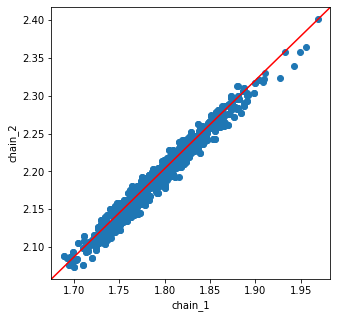

chain_1 chain_3 1.03179245570726 0.025268000327227758


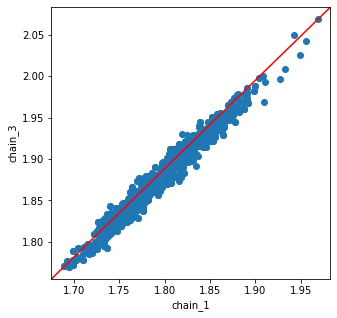

chain_1 chain_4 1.145644697038888 0.1493437547524896


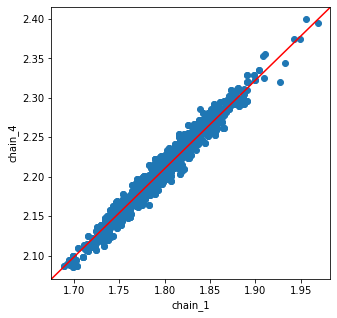

chain_1 chain_5 0.9666464695367577 0.004076907502577528


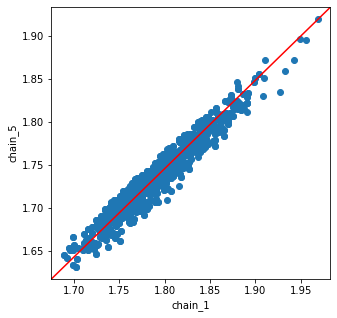

chain_2 chain_3 0.8837366377993539 -0.06177138592455348


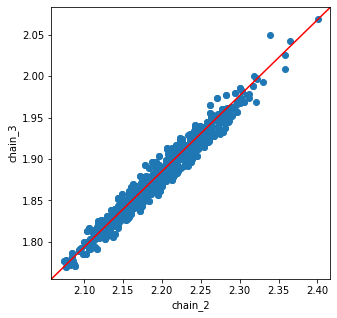

chain_2 chain_4 0.9799803095333095 0.05548862731105727


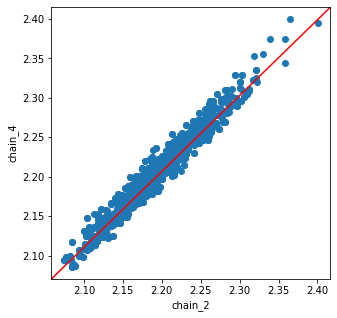

chain_2 chain_5 0.8363949182942143 -0.09601269032442299


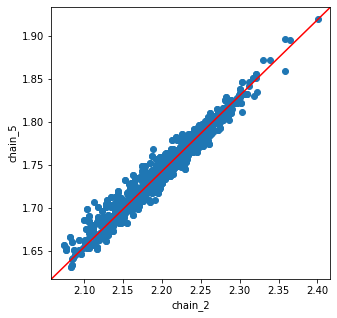

chain_3 chain_4 1.0931446047915923 0.1535606909812818


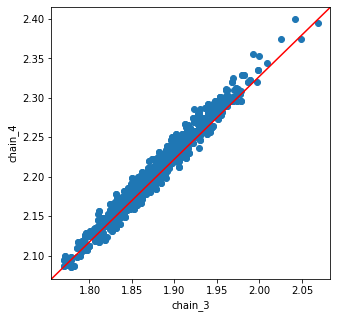

chain_3 chain_5 0.9224528208188796 0.007440387361041249


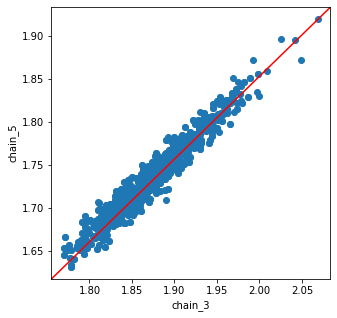

chain_4 chain_5 0.8408359881276517 -0.11549155975630429


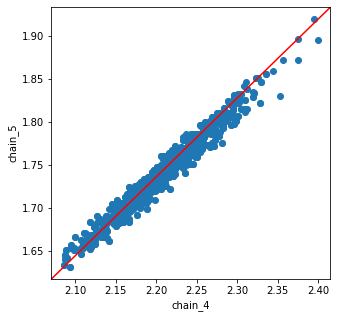

In [17]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')  # add 1:1 line in red
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

<a id='avg'></a>
#### estimate average covariance matrix

[top](#home)

In [18]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.896077,1.828776,1.851364,1.815489,1.824268,1.799836,1.749048,1.764784,1.810078,1.767725,1.797100,1.746960,1.734753,1.782669,1.821580,1.781082,1.733325,1.731371,1.846135,1.820688,1.751662,1.766956,1.822827,1.773984,1.805030,1.795478,1.806513,1.805328,1.819698,1.740125,1.781860,1.801232,1.786172,1.764268,1.744189
1,1.828776,1.872377,1.838179,1.796816,1.802378,1.781681,1.732654,1.749912,1.792030,1.742370,1.777598,1.731923,1.716739,1.760096,1.798431,1.764182,1.715323,1.711118,1.825266,1.802447,1.730713,1.751334,1.806183,1.765514,1.803175,1.776467,1.785166,1.786126,1.796851,1.729508,1.778470,1.794548,1.768468,1.742118,1.724629
2,1.851364,1.838179,1.919194,1.828947,1.831518,1.810248,1.753781,1.776613,1.824684,1.770523,1.805317,1.756726,1.739125,1.785489,1.832935,1.786223,1.740962,1.732395,1.855494,1.832432,1.757352,1.767988,1.827826,1.787795,1.817250,1.794407,1.809245,1.810453,1.822378,1.750584,1.796687,1.816575,1.795039,1.769713,1.747516
3,1.815489,1.796816,1.828947,1.829970,1.807432,1.778807,1.722132,1.740057,1.797804,1.739194,1.771040,1.723649,1.698977,1.749747,1.793395,1.751494,1.705409,1.700065,1.821861,1.807230,1.726090,1.737358,1.795294,1.751136,1.772430,1.758769,1.775437,1.775667,1.783237,1.711623,1.757510,1.773247,1.758450,1.735980,1.713993
4,1.824268,1.802378,1.831518,1.807432,1.846663,1.780707,1.734555,1.749430,1.801693,1.744501,1.784835,1.733706,1.711032,1.762917,1.805728,1.764024,1.712520,1.713572,1.825167,1.810133,1.735386,1.747685,1.799538,1.749284,1.778348,1.769057,1.782500,1.782443,1.791289,1.720312,1.760819,1.779579,1.772159,1.746031,1.725838


In [19]:
chain

'chain_5'

In [20]:
for chain,m in mats.items():
    print(chain)
    if 'chain_1' in chain:
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

chain_1
chain_2
chain_3
chain_4
chain_5


array([[10.603287, 10.239419, 10.379428, ..., 10.020315,  9.900135,
         9.78367 ],
       [10.239419, 10.462271, 10.304242, ...,  9.914322,  9.785157,
         9.672628],
       [10.379428, 10.304242, 10.752145, ..., 10.079761,  9.954554,
         9.814848],
       ...,
       [10.020315,  9.914322, 10.079761, ..., 10.009319,  9.701269,
         9.574536],
       [ 9.900135,  9.785157,  9.954554, ...,  9.701269,  9.912039,
         9.425235],
       [ 9.78367 ,  9.672628,  9.814848, ...,  9.574536,  9.425235,
         9.540671]])

In [21]:
avg = summatrix / len(mats)
avg.shape

(35, 35)

In [22]:
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

(35, 35)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,2.120657,2.047884,2.075886,2.050132,2.043232,2.022917,1.983806,1.992479,2.035399,1.986059,2.017990,1.955775,1.962656,1.996863,2.049298,1.999672,1.949576,1.955102,2.071804,2.044024,1.972346,1.990092,2.044927,2.003277,2.032290,2.018575,2.035187,2.037224,2.049050,1.960078,1.995571,2.019770,2.004063,1.980027,1.956734
1,2.047884,2.092454,2.060848,2.028603,2.019734,2.001937,1.962491,1.975751,2.016545,1.957685,1.995022,1.937106,1.941190,1.970003,2.024362,1.980620,1.930379,1.932619,2.050163,2.021476,1.949010,1.972978,2.024118,1.990904,2.029644,1.996092,2.008928,2.016859,2.024274,1.948031,1.988482,2.010727,1.982864,1.957031,1.934526
2,2.075886,2.060848,2.150429,2.065182,2.053459,2.034590,1.991737,2.007710,2.052182,1.991834,2.027320,1.967112,1.966416,2.002807,2.062456,2.008311,1.959222,1.959428,2.082829,2.058731,1.979976,1.996141,2.052325,2.020347,2.046416,2.020318,2.037975,2.044615,2.057065,1.973950,2.015007,2.036187,2.015952,1.990911,1.962970
3,2.050132,2.028603,2.065182,2.081745,2.039016,2.014002,1.966622,1.978925,2.038059,1.969597,2.002124,1.943555,1.937218,1.975941,2.032845,1.983800,1.931578,1.935616,2.062805,2.044322,1.957706,1.974083,2.027788,1.989870,2.011616,1.993462,2.013649,2.021877,2.026329,1.942251,1.981950,2.003617,1.989374,1.964106,1.937904
4,2.043232,2.019734,2.053459,2.039016,2.064819,2.003026,1.964688,1.975282,2.028205,1.959097,2.001986,1.939876,1.936115,1.975430,2.030464,1.981655,1.927551,1.934779,2.050071,2.030986,1.953346,1.969205,2.018114,1.974702,2.004657,1.987785,2.005808,2.012077,2.019172,1.938939,1.970861,1.995380,1.987556,1.961164,1.935936


<a id='compare'></a>
#### compare avg matrix to replicate matrices

[top](#home)

In [23]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

1225 1225
chain_1 (0.9913889232966697, 0.0)
chain_2 (0.9921662573280401, 0.0)
chain_3 (0.9916805486057036, 0.0)
chain_4 (0.9937611902356136, 0.0)
chain_5 (0.9862560818563096, 0.0)


In [24]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

In [25]:
# save average matrix
omegafile = op.join(baydir, 'interior_neutral_average_omegafile_noheaderidx.txt')
avgmat.to_csv(omegafile, sep='\t', index=False, header=False)

#### make sure pops are in same order as gfile

In [26]:
# load file to look
poolsizefile = pd.read_table(op.join(baydir, 'interior_poolsizefile_HEADERIDX.txt'))
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,78,80,80,80,80


In [27]:
# load file to look
gfile = pd.read_table(op.join(baydir, 'interior_neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9


In [28]:
# compare computationally
assert list(poolsizefile.columns) == gfilecols

In [29]:
# now apply to avgmat
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
DF_p18,2.120657,2.047884,2.075886,2.050132,2.043232,2.022917,1.983806,1.992479,2.035399,1.986059,2.017990,1.955775,1.962656,1.996863,2.049298,1.999672,1.949576,1.955102,2.071804,2.044024,1.972346,1.990092,2.044927,2.003277,2.032290,2.018575,2.035187,2.037224,2.049050,1.960078,1.995571,2.019770,2.004063,1.980027,1.956734
DF_p19,2.047884,2.092454,2.060848,2.028603,2.019734,2.001937,1.962491,1.975751,2.016545,1.957685,1.995022,1.937106,1.941190,1.970003,2.024362,1.980620,1.930379,1.932619,2.050163,2.021476,1.949010,1.972978,2.024118,1.990904,2.029644,1.996092,2.008928,2.016859,2.024274,1.948031,1.988482,2.010727,1.982864,1.957031,1.934526
DF_p20,2.075886,2.060848,2.150429,2.065182,2.053459,2.034590,1.991737,2.007710,2.052182,1.991834,2.027320,1.967112,1.966416,2.002807,2.062456,2.008311,1.959222,1.959428,2.082829,2.058731,1.979976,1.996141,2.052325,2.020347,2.046416,2.020318,2.037975,2.044615,2.057065,1.973950,2.015007,2.036187,2.015952,1.990911,1.962970
DF_p3,2.050132,2.028603,2.065182,2.081745,2.039016,2.014002,1.966622,1.978925,2.038059,1.969597,2.002124,1.943555,1.937218,1.975941,2.032845,1.983800,1.931578,1.935616,2.062805,2.044322,1.957706,1.974083,2.027788,1.989870,2.011616,1.993462,2.013649,2.021877,2.026329,1.942251,1.981950,2.003617,1.989374,1.964106,1.937904
DF_p33,2.043232,2.019734,2.053459,2.039016,2.064819,2.003026,1.964688,1.975282,2.028205,1.959097,2.001986,1.939876,1.936115,1.975430,2.030464,1.981655,1.927551,1.934779,2.050071,2.030986,1.953346,1.969205,2.018114,1.974702,2.004657,1.987785,2.005808,2.012077,2.019172,1.938939,1.970861,1.995380,1.987556,1.961164,1.935936


In [30]:
# save pop labels
avgmat.to_csv(op.join(baydir, 'interior_neutral_average_omegafile_HEADERIDX.txt'))

<a id='geainfiles'></a>
# create infiles for baypass GEA

[top](#home) 

<a id='efile'></a>
## make efile

[top](#home)

In [31]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

In [32]:
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,78,80,80,80,80


In [33]:
# load environmental data for natural interior pops
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_std_env-19variables_change-p6.txt')
envdata.index = envdata['our_id'].tolist()
envdata = envdata[envdata.index.isin(poolsizefile.columns)]
envdata

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p3,3,DF_p3,FDI,-115.62,50.54,1525,-1.282859,-1.144954,-1.063121,0.496712,-0.241814,1.029838,-0.527788,-1.268265,1.280919,-1.182331,-1.333825,1.341057,-1.307728,-1.358463,-0.065544,-1.209418,-0.935929,-0.807659,-1.333377
DF_p4,4,DF_p4,FDI,-122.33,52.04,900,-0.129003,-0.173788,-0.518596,0.786461,-0.973008,-0.852176,0.932175,0.614478,0.211358,-0.098611,-0.157274,-0.073711,-0.173775,-0.035109,-0.756219,-0.551004,-0.002320,-0.333044,0.462248
DF_p5,5,DF_p5,FDI,-119.05,49.02,853,0.924519,1.052949,0.570455,0.351838,-1.170820,-1.228578,2.037286,1.928260,-0.722439,1.109054,0.851199,-1.072370,0.857092,1.004668,-1.058390,0.595910,1.134249,0.938924,1.788663
DF_p7,7,DF_p7,FDI,-122.13,53.98,684,-0.379841,-0.327130,-0.917914,1.365959,0.641271,1.330960,-0.862363,-1.159646,0.582227,-0.197131,0.010805,-0.406597,-0.070688,0.201204,0.618965,-0.614722,-0.530012,-0.769690,-1.125842
DF_p8,8,DF_p8,FDI,-124.38,54.35,850,-1.032021,-0.991612,-1.280932,1.148647,-0.446690,-0.264987,-0.264184,-0.409652,1.174956,-0.985291,-0.787569,0.758505,-0.689208,-0.744049,-0.059377,-0.997026,-1.017113,-1.063952,-0.530308
DF_p9,9,DF_p9,FDI,-119.72,53.12,780,-0.630679,-0.633814,-0.663803,0.496712,-0.552660,-0.355324,0.009559,-0.166550,0.651765,-0.524472,-0.325352,0.092733,-0.173775,-0.129635,-0.287547,-0.635961,-0.854746,-0.893090,-0.358867
DF_p18,18,DF_p18,FDI,-116.83,48.33,823,1.225525,1.206291,1.151283,-0.589846,0.468187,-0.310156,-0.375709,0.593788,-1.232384,1.172615,1.187356,-0.905927,0.960178,0.957406,-0.201212,1.360519,1.174840,1.280647,0.832200
DF_p19,19,DF_p19,FDI,-116.00,45.83,686,2.078375,2.024115,2.022523,-1.169344,-0.114650,0.563098,0.384689,0.076551,-1.801934,2.141925,2.069770,-1.654921,1.681785,1.713607,-1.243392,1.891498,2.067858,2.239370,0.624666
DF_p20,20,DF_p20,FDI,-114.50,48.08,1341,0.523177,0.746265,0.715662,-0.372534,-0.803456,-0.566110,0.871343,0.681719,-0.686014,0.552893,0.346963,-0.156932,0.135485,0.153941,-0.854887,0.829540,0.606556,0.445325,0.886340
DF_p33,33,DF_p33,FDI,-116.25,51.03,1524,-1.634033,-1.502752,-1.317233,0.496712,0.715450,1.075006,-1.176661,-1.407920,1.734572,-1.509672,-1.543923,1.257835,-1.720074,-1.500250,1.476143,-1.421809,-1.138888,-1.092429,-1.513841


In [34]:
# triple check centered/standardized
print(len(list(envdata.columns)[6:]))
for env in list(envdata.columns)[6:]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

19
MAT 2.569373285561077e-16 0.9999999999999999
MWMT -1.2783425112112517e-15 1.0
MCMT 6.24896959574731e-16 1.0
TD 2.4313884239290927e-15 0.9999999999999998
MAP -1.9032394707859825e-16 1.0
MSP 5.947623346206196e-17 1.0
AHM 2.5059319698682104e-16 0.9999999999999999
SHM -3.425831047414769e-16 1.0
DD_0 -1.9032394707859827e-17 1.0
DD5 -1.4115692741662704e-16 0.9999999999999998
NFFD 3.8381995994183985e-16 1.0
bFFP 1.1482878140408763e-15 1.0000000000000002
eFFP -2.6708793906696623e-15 1.0
FFP -2.220446049250313e-16 1.0
PAS -2.5376526277146434e-17 1.0
EMT -4.758098676964957e-18 0.9999999999999999
EXT -1.5479681029059326e-15 1.0000000000000002
Eref 1.586032892321652e-17 0.9999999999999999
CMD 2.283887364943179e-16 1.0000000000000002


In [35]:
# convert envdata to efile, making sure to order pops in same order as other files
efile = envdata.loc[poolsizefile.columns.tolist(), list(envdata.columns)[6:]]
efile.head()

,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p18,1.225525,1.206291,1.151283,-0.589846,0.468187,-0.310156,-0.375709,0.593788,-1.232384,1.172615,1.187356,-0.905927,0.960178,0.957406,-0.201212,1.360519,1.174840,1.280647,0.832200
DF_p19,2.078375,2.024115,2.022523,-1.169344,-0.114650,0.563098,0.384689,0.076551,-1.801934,2.141925,2.069770,-1.654921,1.681785,1.713607,-1.243392,1.891498,2.067858,2.239370,0.624666
DF_p20,0.523177,0.746265,0.715662,-0.372534,-0.803456,-0.566110,0.871343,0.681719,-0.686014,0.552893,0.346963,-0.156932,0.135485,0.153941,-0.854887,0.829540,0.606556,0.445325,0.886340
DF_p3,-1.282859,-1.144954,-1.063121,0.496712,-0.241814,1.029838,-0.527788,-1.268265,1.280919,-1.182331,-1.333825,1.341057,-1.307728,-1.358463,-0.065544,-1.209418,-0.935929,-0.807659,-1.333377
DF_p33,-1.634033,-1.502752,-1.317233,0.496712,0.715450,1.075006,-1.176661,-1.407920,1.734572,-1.509672,-1.543923,1.257835,-1.720074,-1.500250,1.476143,-1.421809,-1.138888,-1.092429,-1.513841


In [36]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
MAT,1.225525,2.078375,0.523177,-1.282859,-1.634033,-1.433362,0.222171,-0.831350,-1.383195,-1.032021,0.322506,-0.129003,-1.182524,-0.279506,-1.032021,0.071668,0.573345,0.172003,-0.630679,-0.680847,-1.232691,1.325860,0.924519,0.523177,2.228878,1.225525,0.623513,0.021500,0.573345,1.024854,0.673680,0.473010,-0.379841,-1.032021,-0.630679
MWMT,1.206291,2.024115,0.746265,-1.144954,-1.502752,-1.298296,0.286238,-1.042726,-1.196068,-0.787156,0.388466,-0.173788,-2.013892,-0.531586,-0.889384,-0.378244,0.644037,0.286238,-0.736042,-0.480472,-0.838270,1.359633,1.052949,0.388466,2.228571,1.206291,0.439581,0.132896,0.439581,0.797379,0.797379,0.541809,-0.327130,-0.991612,-0.633814
MCMT,1.151283,2.022523,0.715662,-1.063121,-1.317233,-0.809009,-0.337087,-0.809009,-1.389837,-1.280932,-0.337087,-0.518596,-0.409691,-0.445992,-1.280932,-0.228182,0.243740,0.062231,0.062231,-0.700104,-1.535043,0.933472,0.570455,1.078679,1.986222,1.042377,0.860869,0.497852,1.078679,1.332791,1.151283,0.534154,-0.917914,-1.280932,-0.663803
TD,-0.589846,-1.169344,-0.372534,0.496712,0.496712,-0.227660,1.076210,0.134526,1.076210,1.438396,1.221085,0.786461,-2.038590,0.134526,1.221085,-0.082785,0.424275,0.351838,-1.169344,0.714024,1.873020,-0.010348,0.351838,-1.676404,-0.807158,-0.372534,-1.096907,-0.807158,-1.459093,-1.459093,-1.169344,-0.300097,1.365959,1.148647,0.496712
MAP,0.468187,-0.114650,-0.803456,-0.241814,0.715450,0.019579,-0.930620,-1.163755,-1.262660,-1.213208,-0.715148,-0.973008,-0.358381,-0.146441,-0.489078,-1.315646,-1.326243,0.945053,3.057392,0.503510,0.722515,-0.690421,-1.170820,-0.273605,-0.058132,0.408137,0.885003,1.407789,1.994158,1.079281,0.605948,0.793162,0.641271,-0.446690,-0.552660


In [37]:
# save
efile.to_csv(op.join(baydir, 'interior_efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'interior_efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

In [38]:
len(efile.columns)

35

<a id='gfile'></a>
## create gfiles for GEA from "SNP" files (ADP < 1000)

[top](#home)

In [ ]:
# RESTART NOTEBOOK!!!

In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 4937ed6baded6e6e058c905e26e9ae16bfe3f0d9
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 1 11:28:39 2020 -0700
Today:	December 16, 2020 - 14:50:08
##################################################################



In [3]:
lview,dview = get_client()

56 56


In [4]:
f = op.join(snpdir, 'DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt')
snps = parallel_read(f,
                     lview=lview, dview=dview,
                     verbose=False)
print(snps.shape)
snps.index = snps['locus'].tolist()
snps.head()


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:24<00:00,  2.26it/s]


(2483660, 295)


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,DF_p20.PVAL,DF_p20.AD,DF_p20.RD,DF_p3.GT,DF_p3.GQ,DF_p3.SDP,DF_p3.DP,DF_p3.FREQ,DF_p3.PVAL,DF_p3.AD,DF_p3.RD,DF_p33.GT,DF_p33.GQ,DF_p33.SDP,DF_p33.DP,DF_p33.FREQ,...,DF_p60.GT,DF_p60.GQ,DF_p60.SDP,DF_p60.DP,DF_p60.FREQ,DF_p60.PVAL,DF_p60.AD,DF_p60.RD,DF_p61.GT,DF_p61.GQ,DF_p61.SDP,DF_p61.DP,DF_p61.FREQ,DF_p61.PVAL,DF_p61.AD,DF_p61.RD,DF_p62.GT,DF_p62.GQ,DF_p62.SDP,DF_p62.DP,DF_p62.FREQ,DF_p62.PVAL,DF_p62.AD,DF_p62.RD,DF_p7.GT,DF_p7.GQ,DF_p7.SDP,DF_p7.DP,DF_p7.FREQ,DF_p7.PVAL,DF_p7.AD,DF_p7.RD,DF_p8.GT,DF_p8.GQ,DF_p8.SDP,DF_p8.DP,DF_p8.FREQ,DF_p8.PVAL,DF_p8.AD,DF_p8.RD,DF_p9.GT,DF_p9.GQ,DF_p9.SDP,DF_p9.DP,DF_p9.FREQ,DF_p9.PVAL,DF_p9.AD,DF_p9.RD,locus,MAF
jcf7190000000000-77657,jcf7190000000000,77657,T,C,0.801333,-10.0,SNP,PASS,16,5,51,26,5,C/C,160.0,43,43.0,81.4%,9.593300e-17,35.0,8.0,C/C,128.0,34,34.0,82.35%,1.349000e-13,28.0,6.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,71.0,20,20.0,80%,7.708600e-08,16.0,4.0,C/C,47.0,11,11.0,90.91%,...,T/C,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,T/C,93.0,30,30.0,73.33%,4.135100e-10,22.0,8.0,C/C,82.0,19,19.0,89.47%,5.941400e-09,17.0,2.0,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,C/C,93.0,21,21.0,90.48%,4.700300e-10,19.0,2.0,T/C,49.0,17,17.0,70.59%,1.128500e-05,12.0,5.0,jcf7190000000000-77657,0.198667
jcf7190000000000-77738,jcf7190000000000,77738,T,C,0.789830,-10.0,SNP,PASS,13,2,49,28,8,T/C,103.0,32,32.0,75%,4.196400e-11,24.0,8.0,C/C,126.0,27,27.0,92.59%,2.085300e-13,25.0,2.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,T/C,29.0,9,9.0,77.78%,...,C/C,71.0,17,17.0,88.24%,7.327700e-08,15.0,2.0,T/C,55.0,17,17.0,76.47%,2.564700e-06,13.0,4.0,C/C,64.0,14,14.0,92.86%,3.739100e-07,13.0,1.0,C/C,63.0,17,17.0,82.35%,4.885100e-07,14.0,3.0,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,T/C,18.0,9,9.0,NaN,1.470600e-02,5.0,4.0,jcf7190000000000-77738,0.210170
jcf7190000000000-77764,jcf7190000000000,77764,T,C,0.934369,-10.0,SNP,PASS,12,1,28,50,8,C/C,127.0,29,29.0,89.66%,1.649600e-13,26.0,3.0,C/C,117.0,21,21.0,100%,1.857800e-12,21.0,0.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,58.0,11,11.0,100%,...,C/C,64.0,12,12.0,100%,3.698000e-07,12.0,0.0,C/C,65.0,16,16.0,87.5%,2.545400e-07,14.0,2.0,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,C/C,58.0,11,11.0,100%,1.417600e-06,11.0,0.0,C/C,52.0,10,10.0,100%,5.412500e-06,10.0,0.0,jcf7190000000000-77764,0.065631
jcf7190000000004-54349,jcf7190000000004,54349,C,T,0.567102,-10.0,SNP,PASS,20,16,67,3,1,C/T,55.0,22,22.0,63.64%,2.781700e-06,14.0,8.0,C/T,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,C/T,37.0,12,12.0,75%,0.000168,9.0,3.0,C/T,17.0,10,10.0,NaN,1.625400e-02,5.0,5.0,C/T,69.0,21,21.0,76.19%,...,C/T,79.0,27,27.0,70.37%,1.208900e-08,19.0,8.0,C/T,35.0,14,14.0,64.29%,2.898600e-04,9.0,5.0,C/T,27.0,20,20.0,40%,1.638000e-03,8.0,12.0,C/T,35.0,23,23.0,43.48%,2.806600e-04,10.0,13.0,C/T,24.0,18,18.0,38.89%,3.812300e-03,7.0,11.0,C/C,6.0,22,22.0,NaN,1.000000e+00,0.0,22.0,jcf7190000000004-54349,0.432898
jcf7190000000004-54418,jcf7190000000004,54418,T,C,0.545079,-10.0,SNP,PASS,36,1,86,0,0,T/C,89.0,39,39.0,58.97%,1.093000e-09,23.0,16.0,T/C,95.0,38,38.0,63.16%,2.566500e-10,24.0,14.0,T/C,59.0,19,19.0,73.68%,0.000001,14.0,5.0,T/C,86.0,36,36.0,61.11%,2.119400e-09,22.0,14.0,T/C,83.0,34,34.0,61.76%,...,T/C,78.0,41,41.0,51.22%,1.468200e-08,21.0,20.0,T/C,41.0,32,32.0,37.5%,6.875100e-05,12.0,20.0,T/C,66.0,37,37.0,48.65%,2.432000e-07,18.0,19.0,T/C,70.0,38,38.0,50%,9.241500e-08,19.0,19.0,T/C,45.0,21,21.0,57.14%,2.658000e-05,12.0,9.0,T/C,88.0,40,40.0,57.5%,1.298900e-09,23.0,17.0,jcf7190000000004-54418,0.454921


In [5]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((2483382, 295), (2483660, 295))

In [6]:
# how many snps were dropped?
nrow(snps) - nrow(reduced)

278

In [10]:
# test function
x = get_counts(reduced.index[:5], 35)
x.head()

100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000000000-77657,35,8,28,6,0,0,16,4,10,1,19,5,9,4,14,2,7,4,20,4,21,2,10,2,0,0,8,6,7,2,15,8,16,5,15,2,15,6,0,0,9,2,14,0,21,4,22,3,13,4,8,2,16,4,9,4,10,1,16,6,22,8,17,2,16,2,19,2,12,5
jcf7190000000000-77738,24,8,25,2,0,0,16,2,7,2,12,6,6,2,11,2,9,1,15,2,10,2,9,2,0,0,6,5,6,3,10,7,10,5,11,4,6,2,0,0,7,3,11,0,15,3,15,5,9,3,6,4,12,1,11,3,9,3,15,2,13,4,13,1,14,3,14,0,0,0
jcf7190000000000-77764,26,3,21,0,0,0,14,0,11,0,18,0,11,0,9,0,0,0,13,1,12,1,11,0,0,0,8,1,7,2,10,6,14,2,11,1,0,0,0,0,7,1,9,0,14,0,16,0,10,2,12,0,11,0,15,1,10,2,12,0,14,2,14,0,11,2,11,0,10,0
jcf7190000000004-54349,14,8,16,6,9,3,0,0,16,5,16,6,16,10,10,5,7,9,15,2,7,7,8,9,0,0,0,0,6,7,6,4,11,9,13,9,7,6,17,7,9,10,6,12,7,10,10,4,14,8,12,11,9,8,12,14,7,17,19,8,9,5,8,12,10,13,7,11,0,0
jcf7190000000004-54418,23,16,24,14,14,5,22,14,21,13,27,21,29,15,18,8,9,12,31,8,9,8,17,13,0,0,9,13,12,9,19,16,22,16,8,25,21,14,23,24,17,18,14,15,18,21,32,11,20,14,19,15,12,22,0,0,12,17,21,20,12,20,18,19,19,19,12,9,23,17


In [11]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

108

In [12]:
# restart engines
lview,dview = get_client()

18 18


In [13]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [14]:
# thresh to evenly distribute jobs
thresh = math.ceil(nrow(reduced) / len(lview))
thresh

137966

In [17]:
# send jobs to engines for get_counts()
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == thresh or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, *(tosend, 35)))
        tosend = []
watch_async(jobs)


Watching 18 jobs ...


100%|██████████| 18/18 [04:06<00:00, 13.69s/it]  


In [18]:
jobs[0].r.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000000000-77657,35,8,28,6,0,0,16,4,10,1,19,5,9,4,14,2,7,4,20,4,21,2,10,2,0,0,8,6,7,2,15,8,16,5,15,2,15,6,0,0,9,2,14,0,21,4,22,3,13,4,8,2,16,4,9,4,10,1,16,6,22,8,17,2,16,2,19,2,12,5
jcf7190000000000-77738,24,8,25,2,0,0,16,2,7,2,12,6,6,2,11,2,9,1,15,2,10,2,9,2,0,0,6,5,6,3,10,7,10,5,11,4,6,2,0,0,7,3,11,0,15,3,15,5,9,3,6,4,12,1,11,3,9,3,15,2,13,4,13,1,14,3,14,0,0,0
jcf7190000000000-77764,26,3,21,0,0,0,14,0,11,0,18,0,11,0,9,0,0,0,13,1,12,1,11,0,0,0,8,1,7,2,10,6,14,2,11,1,0,0,0,0,7,1,9,0,14,0,16,0,10,2,12,0,11,0,15,1,10,2,12,0,14,2,14,0,11,2,11,0,10,0
jcf7190000000004-54349,14,8,16,6,9,3,0,0,16,5,16,6,16,10,10,5,7,9,15,2,7,7,8,9,0,0,0,0,6,7,6,4,11,9,13,9,7,6,17,7,9,10,6,12,7,10,10,4,14,8,12,11,9,8,12,14,7,17,19,8,9,5,8,12,10,13,7,11,0,0
jcf7190000000004-54418,23,16,24,14,14,5,22,14,21,13,27,21,29,15,18,8,9,12,31,8,9,8,17,13,0,0,9,13,12,9,19,16,22,16,8,25,21,14,23,24,17,18,14,15,18,21,32,11,20,14,19,15,12,22,0,0,12,17,21,20,12,20,18,19,19,19,12,9,23,17


In [19]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [20]:
# make sure returns make sense
nrow(reduced) == nrow(gfile)

True

In [21]:
# make sure returns make sense
nrow(reduced) == luni(gfile.index)

True

In [22]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

In [23]:
# restart engines
lview,dview = get_client()

56 56


In [24]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [25]:
jobs = []
files = [op.join(baydir, 'interior_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'interior_all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in files:
    jobs.append(lview.apply_async(write_file, *(gfile, f)))

In [26]:
watch_async(jobs)


Watching 2 jobs ...


100%|██████████| 2/2 [00:25<00:00, 12.65s/it]


<a id='gparallel'></a>
### break up gfile for parallelization

[top](#home)

In [27]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

In [28]:
# create a directory to break up main gfile into tiny gfiles for parallel baypass calls
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles'

In [29]:
# how many files if I split up main gfile into gfiles with 1500 SNPs each?
nrow(gfile)/1500

1655.588

In [30]:
len(lview)

56

In [31]:
# write small gfiles to parallelize baypass
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 1500 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        bname = 'interior_all_snps_ADP-lt-1000_gfile_noheaderidx.txt'.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
        smallpath = op.join(gfile_dir, bname)
        newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        pkldump(list(smallgfile.index), smallpath.replace(".txt", ".pkl"))  # save list of loci for later
        tosend = []
        jobcount += 1
watch_async(newjobs)


Watching 1656 jobs ...


100%|██████████| 1656/1656 [00:00<00:00, 206602.44it/s]


In [32]:
# make sure no errors
for j in jobs:
    assert op.exists(j.r)

In [33]:
# make sure number of files makes sense
files = fs(gfile_dir, endswith='.txt')
pkls = fs(gfile_dir, endswith='.pkl')
len(files) == len(pkls)

True

In [34]:
smallgfile.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190016526449-17436,47,23,47,68,14,14,39,35,56,27,53,35,41,57,38,29,17,30,55,8,30,27,44,29,22,13,33,29,20,11,56,32,71,34,63,21,49,22,44,39,66,44,73,34,28,22,78,26,41,37,45,22,73,18,55,48,41,16,92,37,73,25,49,54,49,38,49,28,36,26
jcf7190016526449-17448,46,25,52,60,15,14,39,36,57,27,48,35,37,57,41,28,19,29,57,7,34,24,44,31,20,13,31,31,20,9,53,30,75,32,65,20,53,25,46,40,66,39,73,29,29,22,79,27,45,38,49,21,74,18,54,48,39,16,88,34,68,23,44,51,51,40,49,26,37,28
jcf7190016526449-17467,45,22,45,42,14,11,36,32,58,26,44,27,35,47,36,31,18,23,0,0,32,24,42,33,21,10,29,30,19,10,47,29,65,30,57,17,52,16,43,33,73,32,68,28,28,18,69,25,43,30,49,16,67,16,53,34,44,15,90,35,67,18,49,43,45,34,50,22,32,26
jcf7190016526449-17469,45,21,44,45,14,11,36,32,57,26,45,27,33,45,35,31,18,23,0,0,32,24,43,33,21,10,29,30,19,11,48,28,63,30,58,18,51,16,42,33,70,32,67,30,28,20,72,25,42,31,50,17,67,16,54,34,46,15,88,33,67,19,47,42,45,34,47,22,32,26
jcf7190016526449-17638,13,17,35,23,11,4,19,18,15,21,21,26,30,18,23,17,14,10,8,26,12,13,26,16,13,7,13,10,9,10,21,15,18,31,21,18,12,15,20,15,23,30,22,21,18,11,23,21,26,13,14,15,13,28,20,26,9,16,15,40,15,32,24,16,27,13,22,16,13,15


In [37]:
# triple check missing data < 25%
majorcols = [col for col in smallgfile if 'major' in col]
for locus in nb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break
missingcount/len(majorcols)

100%|██████████| 882/882 [00:00<00:00, 3910.98it/s]


0.14285714285714285

<a id='commands'></a>
# create commands to run baypass GEA using gfiles from above

[top](#home)

In [38]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles'

In [39]:
# get gfiles
gfiles = fs(gfile_dir, pattern='noheader', endswith='.txt')
len(gfiles)

1656

In [40]:
# get efile
efile = op.join(baydir, 'interior_efile_std_noheaderidx.txt')
op.exists(efile)

True

In [41]:
# get omegafile and poolsize file
omegafile = op.join(baydir, 'interior_neutral_average_omegafile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'interior_poolsizefile_noheaderidx.txt')
op.exists(omegafile), op.exists(poolsizefile)

(True, True)

In [42]:
cmddir = makedir(op.join(baydir, 'cmd_files'))
cmddir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files'

#### as a rule of thumb, d0yij can be set to 1/5th the minimum pool size

In [44]:
# set compute canada dirs
cbay = '/scratch/lindb/interior_baypass'
ccmddir = op.join(cbay, 'cmd_files')
cres = op.join(ccmddir, 'results')
csh = op.join(ccmddir, 'shfiles')
for d in [ccmddir, cres, csh]:
    print('mkdir -p', d)

mkdir -p /scratch/lindb/interior_baypass/cmd_files
mkdir -p /scratch/lindb/interior_baypass/cmd_files/results
mkdir -p /scratch/lindb/interior_baypass/cmd_files/shfiles


In [45]:
# create baypass commands for each gfile for 5 chains each
cmds = []
for gfile in nb(gfiles):
    for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']:
        seed = random.randint(1, 100000)
        bname = op.basename(gfile).split("_noheader")[0]
        outprefix = f"{bname}_{chain}"
        cmd = f'i_baypass -gfile {gfile.replace(baydir, cbay)} \
-efile {efile.replace(baydir, cbay)} \
-omegafile {omegafile.replace(baydir, cbay)} \
-poolsizefile {poolsizefile.replace(baydir, cbay)} \
-outprefix {outprefix} \
-d0yij 8 \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-npilot 40 '
        cmds.append(cmd)
len(cmds)

100%|██████████| 1656/1656 [00:00<00:00, 10034.52it/s]


8280

In [47]:
cmds[0].split()

['i_baypass',
 '-gfile',
 '/scratch/lindb/interior_baypass/individual_gfiles/interior_all_snps_ADP-lt-1000_gfile_0000_noheaderidx.txt',
 '-efile',
 '/scratch/lindb/interior_baypass/interior_efile_std_noheaderidx.txt',
 '-omegafile',
 '/scratch/lindb/interior_baypass/interior_neutral_average_omegafile_noheaderidx.txt',
 '-poolsizefile',
 '/scratch/lindb/interior_baypass/interior_poolsizefile_noheaderidx.txt',
 '-outprefix',
 'interior_all_snps_ADP-lt-1000_gfile_0000_chain_1',
 '-d0yij',
 '8',
 '-seed',
 '14481',
 '-pilotlength',
 '1000',
 '-nval',
 '50000',
 '-npilot',
 '40']

<a id='catfiles'></a>
### create catfiles to hold commands

[top](#home)

In [160]:
# create catfiles for baypass commands - request 1 node with 32 CPUs
rundir = makedir(op.join(cmddir, 'run_01'))
catfiles = []
tocat = []
for i,cmd in enumerate(nb(cmds)):
    tocat.append(cmd)
    if len(tocat) == 32 or (i+1) == len(cmds):
        file = op.join(rundir, 'catfile_%s.txt' % str(len(catfiles)).zfill(4))
        with open(file, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file)
len(catfiles)

100%|██████████| 8280/8280 [00:00<00:00, 231854.81it/s]


259

In [131]:
catfiles[0]

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/run_01/catfile_0000.txt'

<a id='geashfiles'></a>
### create slurm shfiles for executing commands in parallel

[top](#home)

In [161]:
# create slurm jobs, cat catfiles at GNU parallel
resdir = makedir(op.join(cmddir, 'results'))
shdir = makedir(op.join(cmddir, 'shfiles'))
shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=batch_{num}
#SBATCH --time=3-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=32
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=brandon.lind@ubc.ca
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/home/lindb/src/baypass_2.2/sources"

cd {cres}

cat {catfile.replace(cmddir, ccmddir)} | parallel -j 32 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py $USER $HOME

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

100%|██████████| 259/259 [00:00<00:00, 11493.07it/s]


259

<a id='transfer'></a>
# transfer to cedar, graham, beluga, and arc

[top](#home)

In [162]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'

In [163]:
# get infiles
files = [efile, omegafile]
files.extend(fs(baydir, 'nohead', exclude=['all_snps', 'neutral_gfile']))
files

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_efile_std_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_neutral_average_omegafile_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_efile_std_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_neutral_average_omegafile_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_poolsizefile_noheaderidx.txt']

In [164]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles'

In [165]:
# get gfiles
gfiles = fs(gfile_dir, exclude='.pkl')
files.extend(gfiles)
len(files)

1661

In [166]:
len(gfiles)

1656

In [167]:
rundir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/run_01'

In [168]:
shdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/shfiles'

In [169]:
# get catfiles and shfiles
files.extend(fs(shdir, endswith='.sh'))
files.extend(fs(rundir, endswith='.txt'))
len(files)

2179

In [170]:
files[0]

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/interior_efile_std_noheaderidx.txt'

In [171]:
cbay

'/scratch/lindb/interior_baypass'

In [172]:
dirs = []
for f in files:
    d = op.dirname(f)
    if d not in dirs:
        dirs.append(d)
sorted(dirs)

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/run_01',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/shfiles',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles']

In [173]:
# make directories on graham
dirs = []
for src in files:
    dstdir = op.dirname(src).replace(baydir, cbay)
    if not dstdir in dirs:
        dirs.append(dstdir)

for d in dirs:
    print('mkdir -p ', d)

mkdir -p  /scratch/lindb/interior_baypass
mkdir -p  /scratch/lindb/interior_baypass/individual_gfiles
mkdir -p  /scratch/lindb/interior_baypass/cmd_files/shfiles
mkdir -p  /scratch/lindb/interior_baypass/cmd_files/run_01


In [174]:
len(catfiles)

259

In [176]:
# transfer in parallel
jobs = []
# for src in files:
for src in shfiles+catfiles:
#     dstdir = 'graham:' + op.dirname(src).replace(baydir, cbay)
    dstdir = 'beluga:' + op.dirname(src).replace(baydir, cbay)    
    jobs.append(lview.apply_async(rsync, *(src, dstdir)))
watch_async(jobs)


Watching 518 jobs ...


100%|██████████| 518/518 [00:23<00:00, 22.41it/s]


In [177]:
# see if any failed (repeat cell until all worked)
needed = []
for i,j in enumerate(jobs):
    if j.ready():
        try:
            if not 'speedup' in '\n'.join(j.r):
                needed.append(files[i])
        except:
            needed.append(files[i])
print(len(needed))
jobs = []
for src in needed:
#     dstdir = 'graham:' + op.dirname(src).replace(baydir, cbay)
    dstdir = 'beluga:' + op.dirname(src).replace(baydir, cbay)
    jobs.append(lview.apply_async(rsync, *(src,dstdir)))
watch_async(jobs)

0

Watching 0 jobs ...


0it [00:00, ?it/s]


In [ ]:
len(gfiles)

In [ ]:
len(shfiles)

In [ ]:
len(catfiles)

In [ ]:
len(gfiles)+len(shfiles)+len(catfiles)  # + the 5 other files

In [ ]:
len(files)